In [1]:
import random
import pandas as pd
import numpy as np
import os
import warnings
import pickle as pkl
import holidays
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

# settings for seaborn plot sizes
import platform
sns.set(rc={'figure.figsize':(20, 10)})

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from darts.timeseries import TimeSeries
from darts.models import DLinearModel, AutoARIMA

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import  LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)  # type: ignore
    # torch.backends.cudnn.deterministic = True  # type: ignore
    # torch.backends.cudnn.benchmark = True  # type: ignore    

seed_everything(42) # Seed 고정

In [2]:
base_path = './data/'

In [3]:
train_data = pd.read_csv(base_path + 'train.csv')

In [4]:
def pre_train_df():
    train_df = train_data.copy()

    train_df = train_df[['ID','price(원/kg)']]
    train_df.columns = ['ID','price']
    return train_df

In [5]:
def split_id(x):
    return x.split('_')

def extract_id(x):
    return x[0]

def pre_init_feature(df):
    """ID에서 품목, 유통법인코드, 지역코드 추출, 날짜 추출"""
    split_series = df['ID'].apply(split_id)
    df['item'] = split_series.apply(lambda x: x[0])
    df['corporation'] = split_series.apply(lambda x: x[1])
    df['location'] = split_series.apply(lambda x: x[2])
    df['ymd'] = split_series.apply(lambda x: x[3])
    
def pre_ymd(df):
    # year, month, day 생성
    df['year'] = df['ymd'].apply(lambda x : int(x[:4]))
    df['month'] = df['ymd'].apply(lambda x : int(x[4:6]))
    df['day'] = df['ymd'].apply(lambda x : int(x[6:]))
    
def pre_timestamp(df):
    """year, month, day 칼럼을 사용하여 datetime 형식인 ts 칼럼 생성"""
    df['ts'] = df.apply(lambda x : pd.Timestamp(year=x.year,
                                                month=x.month,
                                                day=x.day),axis=1)
    
def pre_weekday(df):
    """ts 칼럼을 사용하여 weekday 칼럼 생성"""
    df['weekday'] = df['ts'].dt.weekday
    
def pre_holiday(df):
    """ts 칼럼을 사용하여 holiday 칼럼 생성"""
    kr_holidays = holidays.KR()
    df['holiday'] = df['weekday'].apply(lambda x : 1 if x == 6 else 0)
    df['holiday'] = df.apply(lambda x : 1 if x.ts in kr_holidays
                                        else x.holiday, axis=1)

def pre_drop(df):
    """불필요한 칼럼 삭제"""
    df.drop(['ID', 'ymd'], axis=1, inplace=True)
    
# 카테고리형 변수 리스트 설정
cat_cols = ['item', 'corporation', 'location',
            'year', 'month', 'weekday', 'holiday']

def pre_cat_label_encoder(df):
    """카테고리형 변수들을 LabelEncoder로 변환 후, 각 인코더를 딕셔너리에 저장"""
    label_encoders = {}
    for col in cat_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
        
    # pickle로 저장
    pkl.dump(label_encoders, open('label_encoders.pkl', 'wb'))
    return label_encoders


def pre_cat_label_encoder_test(df):
    """test 데이터 변환 시 사용"""
    # pickle로 저장한 label_encoders를 불러와서 정의하기
    label_encoders = pkl.load(open('label_encoders.pkl', 'rb'))
    
    for col in cat_cols:
        try:
            df[col] = label_encoders[col].transform(df[col])
        except:
            print('train에 없는 값이 test에 존재합니다.')
            df[col] = 0
            
def pre_cat_onehot_encoder(df, drop_col=True):
    """카테고리형 변수들을 OneHotEncoder로 변환 후 N-1 인코딩을 적용"""
    onehot_encoders = {}
    for col in cat_cols:
        onehot_encoders[col] = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_data = onehot_encoders[col].fit_transform(df[[col]])
        
        # 원-핫 인코딩된 데이터를 DataFrame으로 변환
        encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoders[col].get_feature_names_out([col]))
        
        # 첫 번째 열(기준 범주)을 제거하여 N-1 인코딩 구현
        encoded_df = encoded_df.iloc[:, 1:]
        
        # 원래 DataFrame에 병합하고, 원본 열 삭제
        if drop_col:
            df = df.drop(col, axis=1).join(encoded_df)
        else:
            df = df.join(encoded_df)
        
    # pickle로 저장
    pkl.dump(onehot_encoders, open('onehot_encoders.pkl', 'wb'))
    return df, onehot_encoders

def pre_cat_onehot_encoder_test(df):
    """테스트 데이터 변환 시 사용"""
    onehot_encoders = pkl.load(open('onehot_encoders.pkl', 'rb'))
    
    for col in cat_cols:
        try:
            encoded_data = onehot_encoders[col].transform(df[[col]])
            encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoders[col].get_feature_names_out([col]))
            
            # 첫 번째 열(기준 범주)을 제거하여 N-1 인코딩 구현
            encoded_df = encoded_df.iloc[:, 1:]
            
            df = df.drop(col, axis=1).join(encoded_df)
        except:
            print(f'{col} 열에 train에 없는 값이 test에 존재합니다.')
            
    return df

In [6]:
def pre_all_label(df):
    """전체 카테고리형 변수 전처리 과정"""
    pre_init_feature(df)
    pre_ymd(df)
    pre_timestamp(df)
    pre_weekday(df)
    pre_holiday(df)
    # pre_drop(df)
    label_encoders = pre_cat_label_encoder(df)
    return df, label_encoders

def pre_all_onehot(df):
    """전체 카테고리형 변수 전처리 과정"""
    pre_init_feature(df)
    pre_ymd(df)
    pre_timestamp(df)
    pre_weekday(df)
    pre_holiday(df)
    pre_drop(df)
    df, onehot_encoders = pre_cat_onehot_encoder(df)
    return df, onehot_encoders

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer

In [7]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [96]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [97]:
train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

In [99]:
# !conda install -c apple tensorflow-deps==2.9.0	# Apple채널에서 의존성 설치
# !pip install tensorflow-macos==2.9.0		# Apple의 macos 전용 tensorflow
# !pip install tensorflow-metal==0.5.0		# GPU 지원

In [100]:
# 데이터 전처리: 'ts' 열 제거
train_df = train_df.drop(columns=['ts'])
test_df = test_df.drop(columns=['ts'])

# 훈련 데이터와 테스트 데이터 준비
X_train = train_df.drop('price', axis=1)
y_train = train_df['price']
X_test = test_df.drop('price', axis=1)
y_test = test_df['price']

In [44]:
def build_basic_model(X_train):
    # 모델 구축
    model = Sequential()
    model.add(InputLayer(input_shape=X_train.shape[1]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류 문제이므로 sigmoid 활성화 함수 사용
    return model

In [45]:
build_basic_model(X_train).summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               4352      
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_base = build_basic_model(X_train)

# 모델 컴파일
model_base.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.Precision()])


In [47]:
history = model_base.fit(X_train,
                         y_train,
                         epochs=40,
                         batch_size=32,
                         validation_split=0.2)

Epoch 1/40


1472/1472 [==============================] - 1s 547us/step - loss: 0.3237 - precision_6: 0.8459 - val_loss: 0.3436 - val_precision_6: 0.9230
Epoch 2/40
1472/1472 [==============================] - 1s 449us/step - loss: 0.2338 - precision_6: 0.8652 - val_loss: 0.2688 - val_precision_6: 0.8665
Epoch 3/40
1472/1472 [==============================] - 1s 456us/step - loss: 0.2119 - precision_6: 0.8727 - val_loss: 0.3399 - val_precision_6: 0.9458
Epoch 4/40
1472/1472 [==============================] - 1s 484us/step - loss: 0.1970 - precision_6: 0.8809 - val_loss: 0.4361 - val_precision_6: 0.9623
Epoch 5/40
1472/1472 [==============================] - 1s 447us/step - loss: 0.1854 - precision_6: 0.8898 - val_loss: 0.2689 - val_precision_6: 0.8844
Epoch 6/40
1472/1472 [==============================] - 1s 445us/step - loss: 0.1773 - precision_6: 0.8952 - val_loss: 0.2831 - val_precision_6: 0.8943
Epoch 7/40
1472/1472 [==============================] - 1s 442us/step - loss: 0.1691 - precision_6:

In [58]:
# Evaluate the model on the test set (테스트 데이터에 대한 예측 결과 평가하기)
test_loss, test_pre = model_base.evaluate(X_test, y_test)
print('Test loss     : %.4f' % test_loss)
print('Test precision : %.4f' % test_pre)

18/18 [==============================] - 0s 394us/step - loss: 0.7655 - precision_6: 0.9091
Test loss     : 0.7655
Test precision : 0.9091


In [48]:
history.history.keys()

dict_keys(['loss', 'precision_6', 'val_loss', 'val_precision_6'])

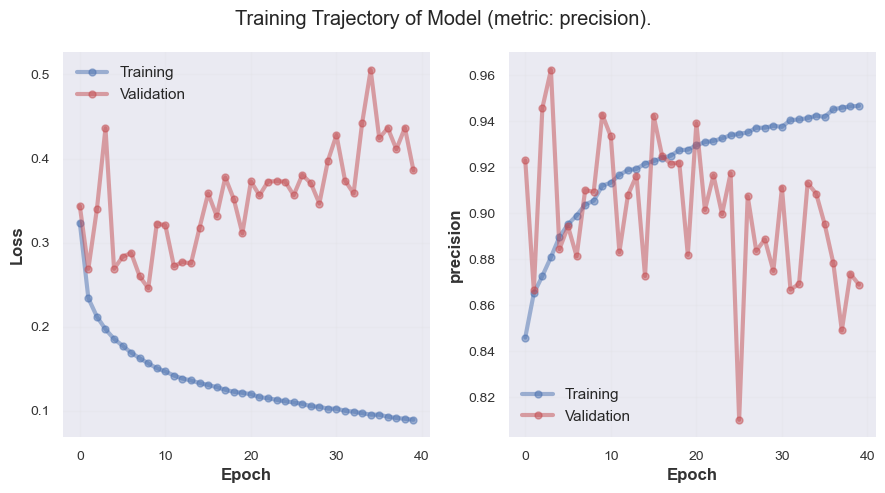

In [49]:
train_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='b')
valid_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='r')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

axes[0].plot(history.history['loss'], label='Training', **train_plot_kws)
axes[0].plot(history.history['val_loss'], label='Validation', **valid_plot_kws)
axes[1].plot(history.history['precision_6'], label='Training', **train_plot_kws)
axes[1].plot(history.history['val_precision_6'], label='Validation', **valid_plot_kws)

axes[0].legend(loc='best')
axes[1].legend(loc='best')

axes[0].grid(True, alpha=.2)
axes[1].grid(True, alpha=.2)

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('precision')

fig.suptitle('Training Trajectory of Model (metric: precision).')
fig.tight_layout(pad=1.01)

plt.show(fig)

# LSTM

In [8]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [9]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [10]:
train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

In [11]:
# 데이터 전처리: 'ts' 열 제거
train_df.drop('ts', axis=1, inplace=True)
test_df.drop('ts', axis=1, inplace=True)

# 모든 칼럼 타입을 float32로 변환
train_df = train_df.astype('float32')
test_df = test_df.astype('float32')

# 훈련 데이터와 테스트 데이터 준비
X_train = train_df.drop('price', axis=1)
y_train = train_df['price']
X_test = test_df.drop('price', axis=1)
y_test = test_df['price']

In [16]:
def build_LSTM_Upgrade_model(X_train):
    # 모델 구축
    # Defining the LSTM model
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류 문제이므로 sigmoid 활성화 함수 사용
    return model

In [18]:
build_LSTM_Upgrade_model(X_train).summary()

ValueError: Input 0 of layer "lstm_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

In [18]:
model_LSTM = build_LSTM_model(X_train)

# 모델 컴파일
model_LSTM.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.Precision()])


In [19]:
history = model_LSTM.fit(tf.convert_to_tensor(X_train.values.reshape(-1, X_train.shape[1], 1), dtype=tf.float32),
                         tf.convert_to_tensor(y_train, dtype=tf.float32),
                         epochs=10,
                         batch_size=32,
                         validation_split=0.2)

Epoch 1/10


2023-12-19 01:49:13.422777: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 238/1472 [===>..........................] - ETA: 23s - loss: 0.6118 - precision: 0.5641

KeyboardInterrupt: 

In [103]:
history.history.keys()

dict_keys(['loss', 'precision_7', 'val_loss', 'val_precision_7'])

In [61]:
# Evaluate the model on the test set (테스트 데이터에 대한 예측 결과 평가하기)
test_loss, test_pre = model_LSTM.evaluate(X_test, y_test)
print('Test loss     : %.4f' % test_loss)
print('Test precision : %.4f' % test_pre)

18/18 [==============================] - 1s 8ms/step - loss: 0.4110 - precision_7: 0.8402
Test loss     : 0.4110
Test precision : 0.8402


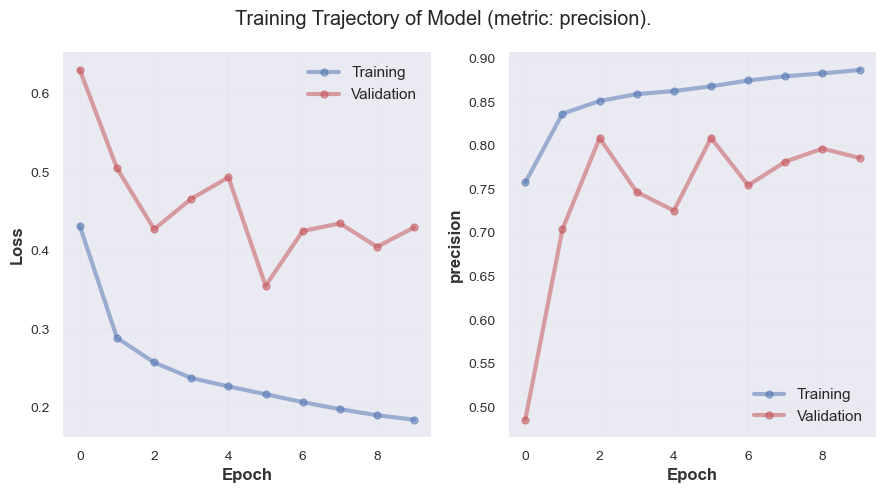

In [60]:
train_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='b')
valid_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='r')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

axes[0].plot(history.history['loss'], label='Training', **train_plot_kws)
axes[0].plot(history.history['val_loss'], label='Validation', **valid_plot_kws)
axes[1].plot(history.history['precision_7'], label='Training', **train_plot_kws)
axes[1].plot(history.history['val_precision_7'], label='Validation', **valid_plot_kws)

axes[0].legend(loc='best')
axes[1].legend(loc='best')

axes[0].grid(True, alpha=.2)
axes[1].grid(True, alpha=.2)

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('precision')

fig.suptitle('Training Trajectory of Model (metric: precision).')
fig.tight_layout(pad=1.01)

plt.show(fig)

In [8]:
train_df = pre_train_df()

In [9]:
pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)
pre_drop(train_df)

In [10]:
train_df, onehot_encoders = pre_cat_onehot_encoder(train_df, drop_col=False)

In [11]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

# 데이터 전처리: 'ts' 열 제거
train_df.drop('ts', axis=1, inplace=True)
test_df.drop('ts', axis=1, inplace=True)

In [12]:
# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [19]:
# 같은 item, corporation, location 별로 LSTM 모델 훈련
model_dict = {}
history_dict = {}

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = train_df[(train_df['item'] == item) &
                       (train_df['corporation'] == corporation) &
                       (train_df['location'] == location)]
    
    # 훈련 데이터와 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_train = temp_df.drop('price', axis=1)
    y_train = temp_df['price']
    
    # 모델 구축
    model = build_LSTM_Upgrade_model(X_train)
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Precision()])
    
    # 모델 훈련
    history = model.fit(X_train.values.reshape(-1, X_train.shape[1], 1),
                        y_train,
                        epochs=10,
                        batch_size=32,
                        validation_split=0.2)
    
    # 모델 저장
    model_dict[f'{item}_{corporation}_{location}'] = model
    history_dict[f'{item}_{corporation}_{location}'] = history
    
    # 모델 저장
    model.save(f'./model/{item}_{corporation}_{location}.h5')

1/39


ValueError: Input 0 of layer "lstm_9" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

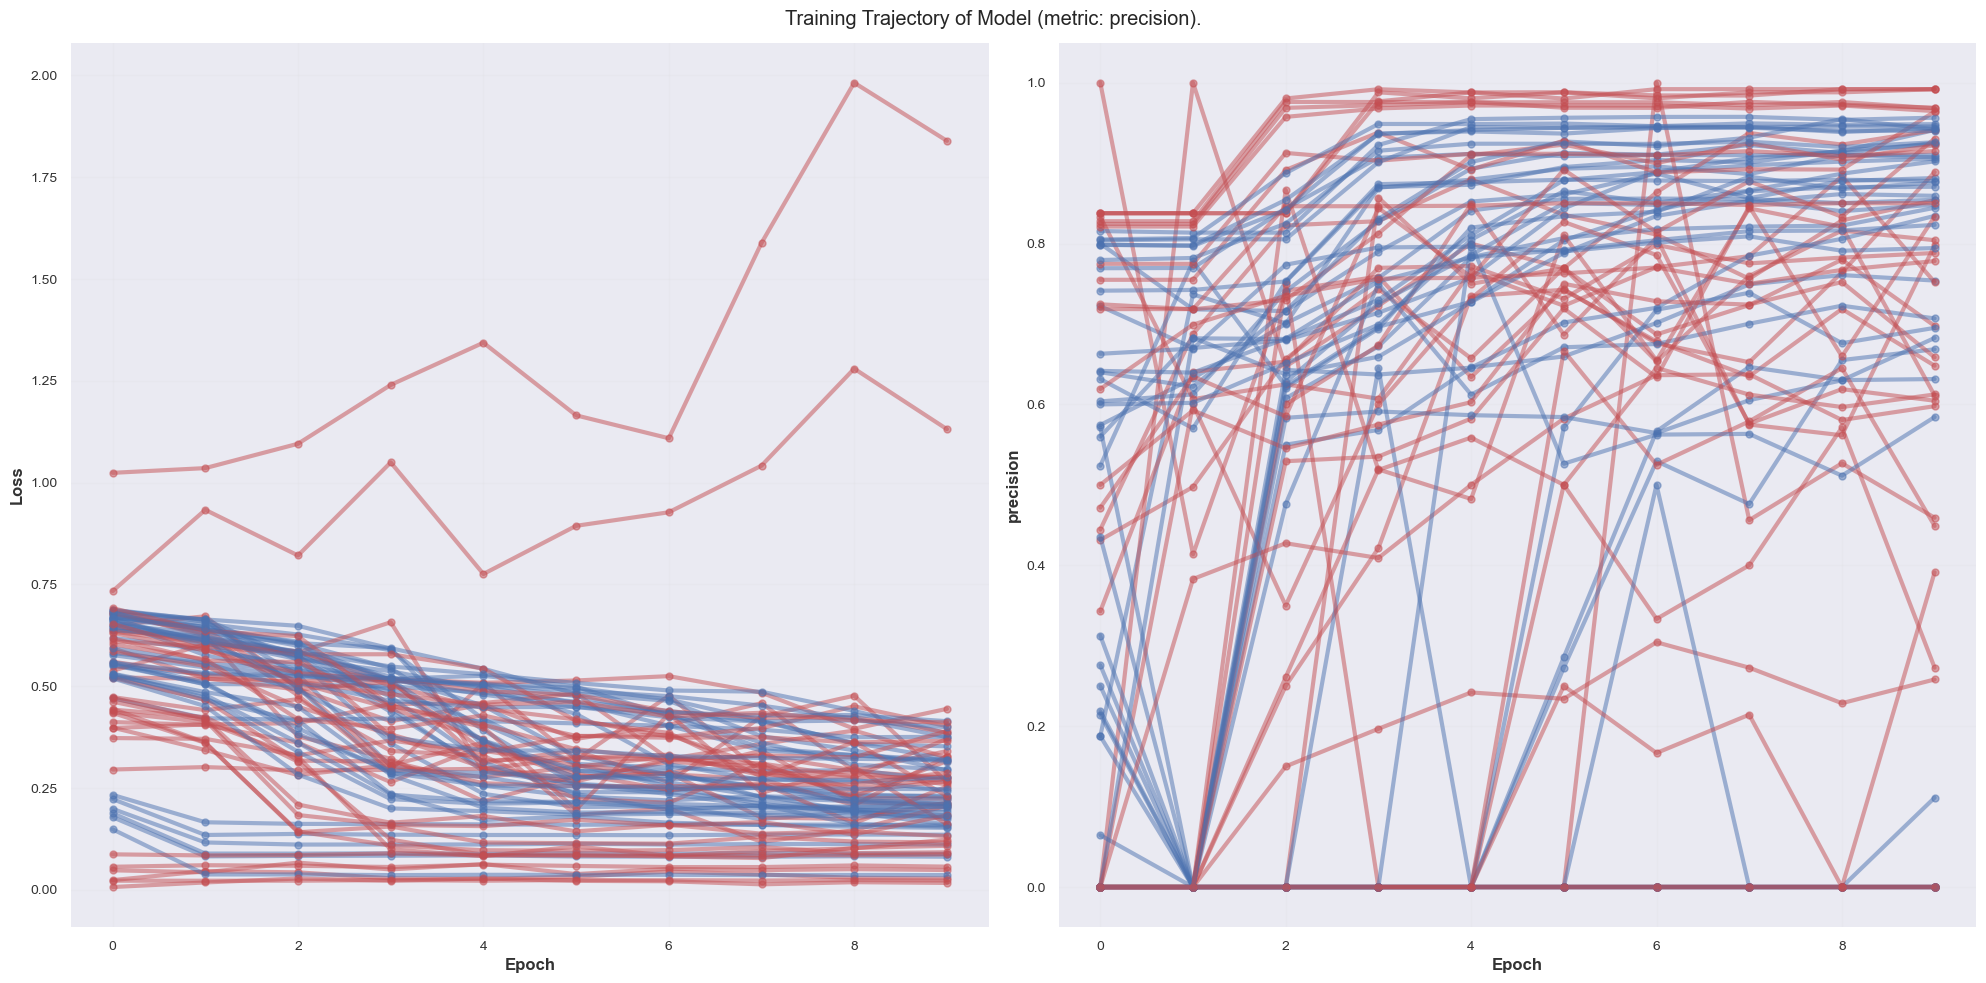

In [179]:
# history_dict 시각화
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for key in history_dict.keys():
    train_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='b')
    valid_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='r')

    columns = list(history_dict[key].history.keys())
    
    axes[0].plot(history_dict[key].history[columns[0]], label='Training', **train_plot_kws)
    axes[0].plot(history_dict[key].history[columns[2]], label='Validation', **valid_plot_kws)
    axes[1].plot(history_dict[key].history[columns[1]], label='Training', **train_plot_kws)
    axes[1].plot(history_dict[key].history[columns[3]], label='Validation', **valid_plot_kws)

# axes[0].legend(loc='best')
# axes[1].legend(loc='best')

axes[0].grid(True, alpha=.2)
axes[1].grid(True, alpha=.2)

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('precision')

fig.suptitle('Training Trajectory of Model (metric: precision).')
fig.tight_layout(pad=1.01)

plt.show(fig)


In [180]:
from sklearn.metrics import precision_score

In [181]:
# test의 특정 item, corporation, location에 대한 예측 결과를 저장할 DataFrame 생성
def test_precision(item, corporation, location):
    # 모델 불러오기
    model = tf.keras.models.load_model(f'./model/{item}_{corporation}_{location}.h5')
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = test_df[(test_df['item'] == item) &
                      (test_df['corporation'] == corporation) &
                      (test_df['location'] == location)]
    
    # 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_test = temp_df.drop('price', axis=1)
    y_test = temp_df['price']
    
    # 예측
    y_pred = model.predict(X_test.values.reshape(-1, X_test.shape[1], 1))
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    
    return y_test, y_pred

# test의 전체 예측 결과를 저장할 DataFrame 생성
y_test_all = []
y_pred_all = []

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 예측
    y_test, y_pred = test_precision(item, corporation, location)
    
    # 예측 결과 저장
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)
    
# 예측 결과 평가
print(f'precision : {precision_score(y_test_all, y_pred_all)}')


1/39
1/1 [==============================] - 0s 464ms/step
2/39
1/1 [==============================] - 0s 362ms/step
3/39
1/1 [==============================] - 0s 341ms/step
4/39
1/1 [==============================] - 0s 347ms/step
5/39
1/1 [==============================] - 0s 344ms/step
6/39
1/1 [==============================] - 0s 335ms/step
7/39
1/1 [==============================] - 0s 340ms/step
8/39
1/1 [==============================] - 0s 337ms/step
9/39
1/1 [==============================] - 0s 336ms/step
10/39
1/1 [==============================] - 0s 337ms/step
11/39
1/1 [==============================] - 0s 332ms/step
12/39
1/1 [==============================] - 0s 329ms/step
13/39
1/1 [==============================] - 0s 326ms/step
14/39
1/1 [==============================] - 0s 329ms/step
15/39
1/1 [==============================] - 0s 328ms/step
16/39
1/1 [==============================] - 0s 330ms/step
17/39
1/1 [==============================] - 0s 329ms/step
18/39


In [182]:
train_df = pre_train_df()

pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)
pre_drop(train_df)

train_df, onehot_encoders = pre_cat_onehot_encoder(train_df, drop_col=False)

# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

# 데이터 전처리: 'ts' 열 제거
train_df.drop('ts', axis=1, inplace=True)
test_df.drop('ts', axis=1, inplace=True)

# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [183]:
# 같은 item, corporation, location 별로 LSTM 모델 훈련
model_dict = {}
history_dict = {}

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = train_df[(train_df['item'] == item) &
                       (train_df['corporation'] == corporation) &
                       (train_df['location'] == location)]
    
    # 훈련 데이터와 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_train = temp_df.drop('price', axis=1)
    y_train = temp_df['price']
    
    # 모델 구축
    model = build_basic_model(X_train)
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Precision()])
    
    # 모델 훈련
    history = model_base.fit(X_train,
                         y_train,
                         epochs=40,
                         batch_size=32,
                         validation_split=0.2)
    
    # 모델 저장
    model_dict[f'{item}_{corporation}_{location}'] = model
    history_dict[f'{item}_{corporation}_{location}'] = history
    
    # 모델 저장
    model.save(f'./model/basic/{item}_{corporation}_{location}.h5')

1/39
Epoch 1/40
38/38 [==============================] - 0s 1ms/step - loss: 0.0307 - precision_6: 0.9898 - val_loss: 0.0335 - val_precision_6: 0.9916
Epoch 2/40
38/38 [==============================] - 0s 756us/step - loss: 0.0235 - precision_6: 0.9932 - val_loss: 0.0348 - val_precision_6: 0.9835
Epoch 3/40
38/38 [==============================] - 0s 699us/step - loss: 0.0182 - precision_6: 0.9949 - val_loss: 0.0418 - val_precision_6: 0.9528
Epoch 4/40
38/38 [==============================] - 0s 723us/step - loss: 0.0192 - precision_6: 0.9949 - val_loss: 0.0247 - val_precision_6: 0.9917
Epoch 5/40
38/38 [==============================] - 0s 769us/step - loss: 0.0176 - precision_6: 0.9932 - val_loss: 0.0228 - val_precision_6: 0.9836
Epoch 6/40
38/38 [==============================] - 0s 755us/step - loss: 0.0173 - precision_6: 0.9932 - val_loss: 0.0313 - val_precision_6: 0.9680
Epoch 7/40
38/38 [==============================] - 0s 703us/step - loss: 0.0169 - precision_6: 0.9949 - val_

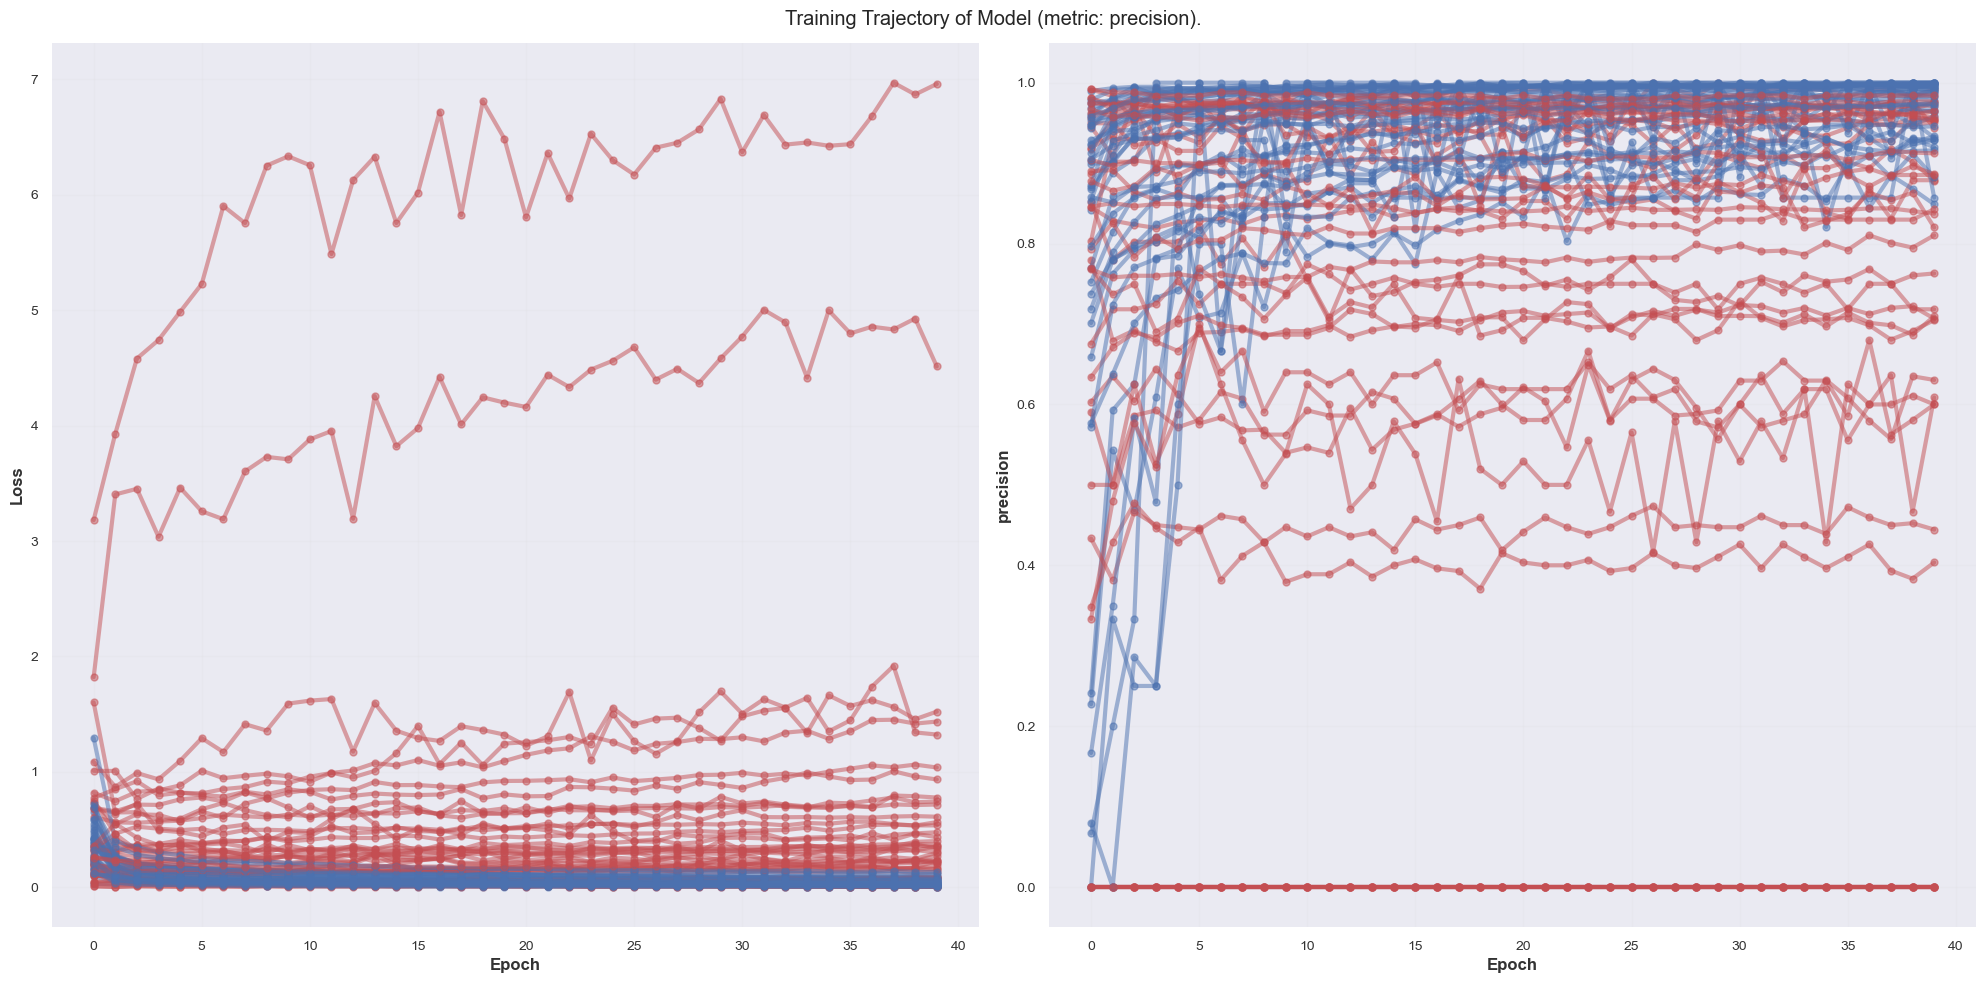

In [185]:
# history_dict 시각화
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for key in history_dict.keys():
    train_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='b')
    valid_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='r')

    columns = list(history_dict[key].history.keys())
    
    axes[0].plot(history_dict[key].history[columns[0]], label='Training', **train_plot_kws)
    axes[0].plot(history_dict[key].history[columns[2]], label='Validation', **valid_plot_kws)
    axes[1].plot(history_dict[key].history[columns[1]], label='Training', **train_plot_kws)
    axes[1].plot(history_dict[key].history[columns[3]], label='Validation', **valid_plot_kws)

# axes[0].legend(loc='best')
# axes[1].legend(loc='best')

axes[0].grid(True, alpha=.2)
axes[1].grid(True, alpha=.2)

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('precision')

fig.suptitle('Training Trajectory of Model (metric: precision).')
fig.tight_layout(pad=1.01)

plt.show(fig)


In [189]:
# test의 특정 item, corporation, location에 대한 예측 결과를 저장할 DataFrame 생성
def test_precision(item, corporation, location):
    # 모델 불러오기
    model = tf.keras.models.load_model(f'./model/basic/{item}_{corporation}_{location}.h5')
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = test_df[(test_df['item'] == item) &
                      (test_df['corporation'] == corporation) &
                      (test_df['location'] == location)]
    
    # 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_test = temp_df.drop('price', axis=1)
    y_test = temp_df['price']
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    # print(precision_score(y_test, y_pred))
    return y_test, y_pred

# test의 전체 예측 결과를 저장할 DataFrame 생성
y_test_all = []
y_pred_all = []

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 예측
    y_test, y_pred = test_precision(item, corporation, location)
    
    # 예측 결과 저장
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)
    
# 예측 결과 평가
print(f'precision : {precision_score(y_test_all, y_pred_all)}')


1/39
1/1 [==============================] - 0s 24ms/step
2/39
1/1 [==============================] - 0s 35ms/step
3/39
1/1 [==============================] - 0s 23ms/step
4/39
1/1 [==============================] - 0s 22ms/step
5/39
1/1 [==============================] - 0s 21ms/step
6/39
1/1 [==============================] - 0s 21ms/step
7/39
1/1 [==============================] - 0s 21ms/step
8/39
1/1 [==============================] - 0s 27ms/step
9/39
1/1 [==============================] - 0s 22ms/step
10/39
1/1 [==============================] - 0s 21ms/step
11/39
1/1 [==============================] - 0s 21ms/step
12/39
1/1 [==============================] - 0s 21ms/step
13/39
1/1 [==============================] - 0s 21ms/step
14/39
1/1 [==============================] - 0s 22ms/step
15/39
1/1 [==============================] - 0s 21ms/step
16/39
1/1 [==============================] - 0s 22ms/step
17/39
1/1 [==============================] - 0s 21ms/step
18/39
1/1 [============

In [42]:
# Defining the LSTM model
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], 1)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 33, 128)           66560     
                                                                 
 dropout_12 (Dropout)        (None, 33, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 206,465
Trainable params: 206,465
Non-tr

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision()])

history = model.fit(X_train.values.reshape(-1, X_train.shape[1], 1),
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

In [190]:
train_df = pre_train_df()

pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)
pre_drop(train_df)

train_df, onehot_encoders = pre_cat_onehot_encoder(train_df, drop_col=False)

# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

# 데이터 전처리: 'ts' 열 제거
train_df.drop('ts', axis=1, inplace=True)
test_df.drop('ts', axis=1, inplace=True)

In [ ]:
# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [193]:
def build_LSTM_Upgrade_model(X_train):
    # 모델 구축
    # Defining the LSTM model
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류 문제이므로 sigmoid 활성화 함수 사용
    return model

In [194]:
# 같은 item, corporation, location 별로 LSTM 모델 훈련
model_dict = {}
history_dict = {}

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = train_df[(train_df['item'] == item) &
                       (train_df['corporation'] == corporation) &
                       (train_df['location'] == location)]
    
    # 훈련 데이터와 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_train = temp_df.drop('price', axis=1)
    y_train = temp_df['price']
    
    # 모델 구축
    model = build_LSTM_model(X_train)
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Precision()])
    
    # 모델 훈련
    history = model.fit(X_train.values.reshape(-1, X_train.shape[1], 1),
                        y_train,
                        epochs=10,
                        batch_size=32,
                        validation_split=0.2)
    
    # 모델 저장
    model_dict[f'{item}_{corporation}_{location}'] = model
    history_dict[f'{item}_{corporation}_{location}'] = history
    
    # 모델 저장
    model.save(f'./model/upgrade/{item}_{corporation}_{location}.h5')

1/39


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).